In [1]:
import sys
from os import getcwd, makedirs
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.spatial.distance import squareform
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [11]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [12]:
dir_roi = su.get_dir_roi()
hem = 'L'

---

In [13]:
list_sn = su.get_list_sn()

In [14]:
list_roi = ['S1','M1','SMA','PMd','PMv','SPLa','SPLp','BA7','POS','Dor','Mid','Ven']

In [15]:
labels = ['(1,L)', '(1,S)', '(2,L)', '(2,S)', '(3,L)', '(3,S)', '(4,L)', '(4,S)']

In [16]:
new_labels = ['(%s,%s)'%(seq+1,cue) for cue in ['L','S'] for seq in range(4)]
new_labels

['(1,L)', '(2,L)', '(3,L)', '(4,L)', '(1,S)', '(2,S)', '(3,S)', '(4,S)']

---

In [17]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [18]:
fname = join(dir_roi, 'SPark.32k.L.dlabel.nii')
cii = nb.load(fname)
mask = cii.get_fdata()[0].astype(int)

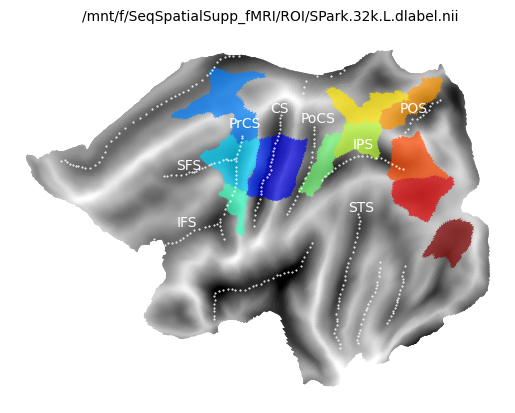

In [19]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

---

In [20]:
def name2cond(name):
    seq = int(name[1])-1
    cue = 0 if 'L' in name else (1 if 'S' in name else 'invalid')
    idx = 2*seq+cue
    return idx+1

In [21]:
def fast_masking(gii, mask):
    betas = {}
    for ii, val in enumerate(np.unique(mask)):
        key = str(val)
        if val == 0:
            continue
        tmp = []
        for jj, darray in enumerate(gii.darrays):
            data = darray.data
            assert data.shape[:3]==mask.shape
            idx = mask==val
            tmp.append(data[idx])
        betas[key] = np.array(tmp)
    
    return betas

In [22]:
def rearrange_mat(square_mat, label_orig, label_arrange):
    A = label_orig
    B = label_arrange
    
    pos_in_A = {val: idx for idx, val in enumerate(A)}
    idx_map = np.array([pos_in_A[val] for val in B])
    
    reordered_mat = square_mat[idx_map][:,idx_map]

    return reordered_mat

---
---

## Load `reginfo.tsv`

In [23]:
reginfo = deal_spm.load_reginfo(subj='S01', dir_glm=dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [24]:
obs_des = {
    'cond_vec': np.array([name2cond(name) for name in reginfo.name]),
    'part_vec': reginfo.run.values
}

### Prewhitening

Both the variance (on-diagonal, see also right panel) and the covariance (off-diagonal) vary substantially across voxels. In part, this is because the beta coefficients are estimated in the presence of noise which is different across voxels and distinctively correlated between voxels. In RSA, we correct for this by prewhitening our beta coefficients ($|\beta\rangle$, $P\times1$):

$$ U_{prewhitened} = U\Sigma^{-\frac{1}{2}}, \phantom{a} |\beta_{i}\rangle_{prewhitened} = \Sigma^{-\frac{1}{2}}|\beta_{i}\rangle $$

Where $\Sigma$ is the (spatial $P\times P$) variance-covariance matrix of the residual $\epsilon$ ($T \times P$) from the first-level GLM, i.e., $\Sigma=\frac{1}{T}\epsilon^{T}\epsilon$. There are two types of prewhitening we can perform on beta coefficients:

- **Univariate prewhitening**: we assume that covariance between voxels is 0 and only correct for differences in noise variance (i.e., the distortion depicted in the left panel of cell 7). To do this, we divide our betas by the square root of the residual mean squares (scalar) stored in the `ResMS.nii` file after GLM estimation with SPM12.
$$
\underset{P\times P}{\Sigma^{-\frac{1}{2}}} = \begin{bmatrix}
\sigma_{1}^{-1} & 0 & \cdots & 0 \\
0 & \sigma_{2}^{-1} & 0 & \vdots \\
\vdots & 0 & \ddots & 0 \\
0 & \cdots & 0 & \sigma_{P}^{-1}
\end{bmatrix}
$$
- **Multivariate prewhitening**: we prewhiten the data using the full covariance ($P\times P$) matrix of the noise $\Sigma$. To perform multivariate prewhitening, we need the full timeseries of the residuals from first-level GLM, which is not output by SPM12. We can retrieve it using the `spm` module of the `nitools` toolbox:

```python
    SPM = spm.SpmGlm('/path/to/glm/folder')
    SPM.get_info_from_spm_mat() # retrieve SPM.mat file
    mask = 'path/to/roi/mask.nii' # in our case, the mask for left S1 
    residuals, _, _ = SPM.get_residuals(mask) # residuals here is a timepoints by voxel matrix
```
For this example, we pre-computed the timeseries of the residuals, let's load it and compute the noise covariance $\Sigma$:

Univariate prewhitening made variances across voxels more homogeneous. The squared Euclidean distance between patterns $|\beta_i\rangle$ and $|\beta_j\rangle$ prewhitened using the covariance of the noise is:

$$ D_{ij}^2 = \big(\langle \beta_i|\Sigma^{-\frac{1}{2}} - \langle\beta_j|\Sigma^{-\frac{1}{2}}\big)\big(\Sigma^{-\frac{1}{2}}|\beta_i\rangle - \Sigma^{-\frac{1}{2}}|\beta_j\rangle\big) $$

We can now group for $ \Sigma^{-1} $:

$$ D_{ij}^2 = \big(\langle\beta_i| - \langle\beta_j|\big) \Sigma^{-1} \big(|\beta_i\rangle - |\beta_j\rangle\big) $$

Expanding:

$$ D_{ij}^2 = \langle\beta_i|\Sigma^{-1}|\beta_i\rangle + \langle\beta_j|\Sigma^{-1}|\beta_j\rangle - 2\langle\beta_j|\Sigma^{-1}|\beta_j\rangle $$

This new distance metric corresponds to the Euclidean distance normalized by the covariance of the noise and is generally referred to as ***Mahalanobis distance***. To obtain the ***cross-validated mahalanobis distance*** or ***crossnobis distance*** we just need to submit the prewhitened beta coefficients to `est_G_crossval` and then transform the G matrix into a squared distance matrix with `G_to_dist`:

In [30]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [31]:
subj = 'S01'
fname = join(dir_work, subj,'%s.%s.glm_%1d.beta.func.gii'%(subj,hem,glm))
gii = nb.load(fname)

In [32]:
betas = fast_masking(gii=gii, mask=mask)

100%|███████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.28it/s]


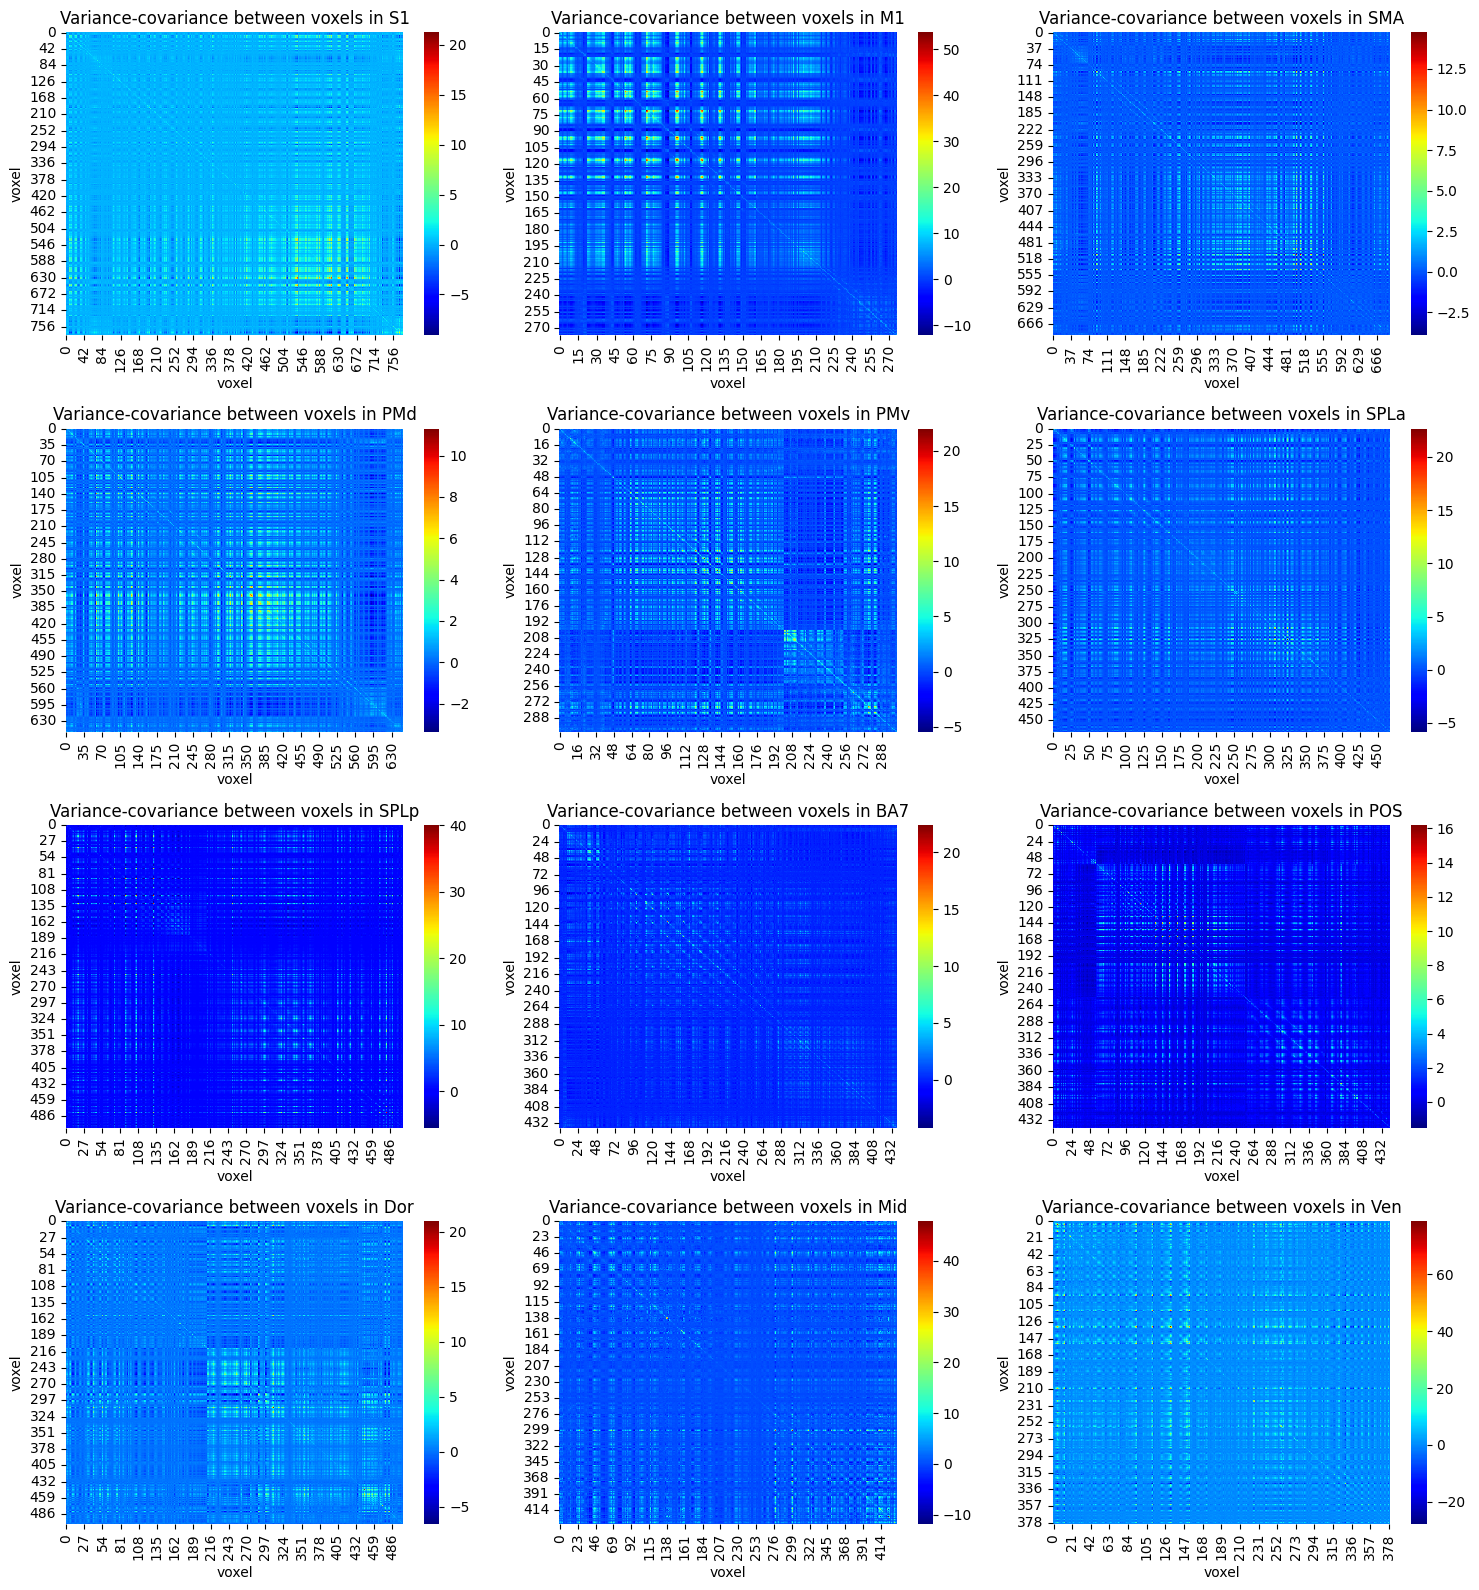

In [33]:
nrows = 4
ncols = 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = np.concatenate(axs)

for ii, (key, beta) in enumerate(tqdm(betas.items())):
    ax = axs[ii]
    _, P= beta.shape
    
    G = beta.T@beta / P
    g = sns.heatmap(G, cmap=cm.jet, ax=ax)
    g.set_xlabel('voxel')
    g.set_ylabel('voxel')
    g.set_title('Variance-covariance between voxels in %s'%list_roi[ii])
fig.tight_layout()

> "GLMsingle improves between-subject representational similarity across datasets" - *Prince 2022*

---
---

### Organizing data by ROI

In [34]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [35]:
Y_dataset = {}
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn
    
    reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
    obs_des = {
        'cond_vec': np.array([name2cond(name) for name in reginfo.name]),
        'part_vec': reginfo.run.values
    }

    fname = join(dir_work, subj,'%s.%s.glm_%1d.beta.func.gii'%(subj,hem,glm))
    gii = nb.load(fname)
    betas = fast_masking(gii=gii, mask=mask) # beta.shape = (nRegressors, nVoxels) for each ROI

    for jj, roi in enumerate(list_roi):
        if ii == 0:
            Y_dataset[roi] = []
            
        key = str(jj+1)
        data = pcm.dataset.Dataset(
            measurements=betas[key],
            obs_descriptors=obs_des
        )
        Y_dataset[roi].append(data)

100%|███████████████████████████████████████████████████| 12/12 [02:10<00:00, 10.84s/it]


## The second moment matrix

A central concept to keep in mind to understand RSA is the **second moment matrix** or $\mathbf{G}$:

$$ G = \frac{{UU^T}}{P} $$

Where $U$ is a $K\times P$ matrix with experimental observations ($K$; e.g., trials, conditions) in the rows and channels ($P$; e.g., electrodes, voxels) in the columns. Therefore, $G$ is a $K\times K$ matrix. In our example case, each row in $U$ contains the beta coefficients estimated in the primary somatosensory cortex (S1) for each condition (i.e., $U=\beta$):
$$
U = \begin{bmatrix}
 & - \langle\beta_{1}| - &  \\
& \vdots &  \\
 & - \langle\beta_{K}| - & 
\end{bmatrix}, \phantom{.}
G_{ij}=\frac{\langle\beta_{i}|\beta_{j}\rangle}{P}
$$

Note that the second moment matrix is different from the ($P\times P$ spatial) variance-covariance matrix:

$$ \mathsf{\Sigma} = \frac{(Y - \bar{Y})^T (Y - \bar{Y})}{T} $$

Here, we subtract the column-wise mean $\bar{Y}$ from $Y$ which is the raw data as $T\times P$ matrix. Instead, the second moment matrix maintains information about the mean activation observed in each condition.

Let's now compute the second moment matrix for the first run in our example data:

Cross-validation
--
The problem with this distance metric is that it will be always (and trivially) larger than zero, even when there is no true distance between conditions. This is because data are collected in the presence of noise. Noise inflates distances: two conditions will be always show some distance relative to each other because noise pulls them apart. More specifically, using the above definition of second moment matrix $G$, in the $n^{th}$ block $G_n$ is estimated as:

$$ G_n = \frac{{U_n U_n^T}}{P} $$

But $U_n$ is affected noise $ \epsilon_n $. Therefore, $G_n$ becomes:

$$ G_n = \frac{1}{P} (U_n + \epsilon_n)(U_n + \epsilon_n)^T $$

Expanding:

$$ G_n = \frac{1}{P} \big( U_n U_n^T + \cancelto{0}{U_n\epsilon_n^T} + \cancelto{0}{\epsilon_n U_n^T} + \epsilon_n \epsilon_n^T \big) $$

$ U_n\epsilon_n^T=0 $  because noise is assumed to be orthogonal to the data. Therefore:

$$ G_n = \frac{1}{P} \big( U_nU_n^T + \epsilon_n \epsilon_n^T \big) $$

$\frac{1}{P}\epsilon_n \epsilon_n^T$ corresponds to the (conditional) covariance of the noise $\Sigma$. Thus, the expected value of $G_n$ estimated in the $n^{th}$ block is:

$$\mathbb{E}[G_n] = G + \Sigma $$

How do we obtain an unbiased $G$ that gets rid of $\Sigma$? In RSA, this is achieved by computing the cross-validated second moment matrix $\hat{G}$ :

$$ \hat{G} = \frac{1}{N} \sum_{i=1}^{N} \frac{U_i \bar{U}_{\neg i}^{T}}{P} $$

Where $N$ is the number of blocks, $U_i$ is the data from $i^{th}$ block and $\bar{U}_{\neg i}$ is the average of all blocks except $i$ :

$$ \bar{U}_{\neg i} = \frac{1}{N-1} \sum_{j \neq i}^{N} U_j $$

The cross-validated second moment matrix between two blocks $i$ and $j$ is:

$$ \hat{G}_{ij} = \frac{U_i U_{j}^{T}}{P} $$

$U_{i}$ and $U_{j}$ will be affected by noise $\epsilon_i$ and $\epsilon_j$:

$$ \hat{G}_{ij} = \frac{1}{P} (U_i + \epsilon_i)(U_j + \epsilon_j)^T $$

Expanding:

$$ \hat{G}_{ij} = \frac{1}{P} \big( U_i U_{j}^T + \cancelto{0}{U_i\epsilon_{j}^T} + \cancelto{0}{\epsilon_i U_{j}^T} + \cancelto{0}{\epsilon_i \epsilon_{j}^T} \big) $$

In this case, not only $U_i\epsilon_{j}^T=0$ and $\epsilon_i U_{j}^T=0$, but also $\epsilon_i \epsilon_{j}^T=0 $ because the noise is assumed to be orthogonal between different blocks. This means that, with cross-validation, we achieved an unbiased estimate of the second moment matrix.

The cross-validated G matrix can be computed in PcmPy using the `est_G_crossval` function. `cond_vec` is  a vector of condition labels and `part_vec` is a vector of partition labels (i.e., the block number):


In [36]:
G_hat_dataset = {}
for roi in tqdm(list_roi):
    Y = Y_dataset[roi]
    G_hat = np.ones((len(list_sn),8,8)) * np.nan
    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        G_hat[ss],_ = pcm.est_G_crossval(
            Y=Y[ss].measurements,
            Z=Y[ss].obs_descriptors['cond_vec'],
            part_vec=Y[ss].obs_descriptors['part_vec'],
            X=pcm.matrix.indicator(Y[ss].obs_descriptors['part_vec'])
        )
        if np.isnan(G_hat[ss]).sum()>0:
            print(' %s: %d'%(subj,np.isnan(Y[ss].measurements).sum()))
            tmp = Y[ss].measurements
    # print('%s: %d'%(roi,np.isnan(G_hat).sum()))
    G_hat_dataset[roi] = G_hat

100%|███████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.22it/s]


In [37]:
for key, value in G_hat_dataset.items():
    print(key, value.shape)

S1 (12, 8, 8)
M1 (12, 8, 8)
SMA (12, 8, 8)
PMd (12, 8, 8)
PMv (12, 8, 8)
SPLa (12, 8, 8)
SPLp (12, 8, 8)
BA7 (12, 8, 8)
POS (12, 8, 8)
Dor (12, 8, 8)
Mid (12, 8, 8)
Ven (12, 8, 8)


100%|███████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.29it/s]


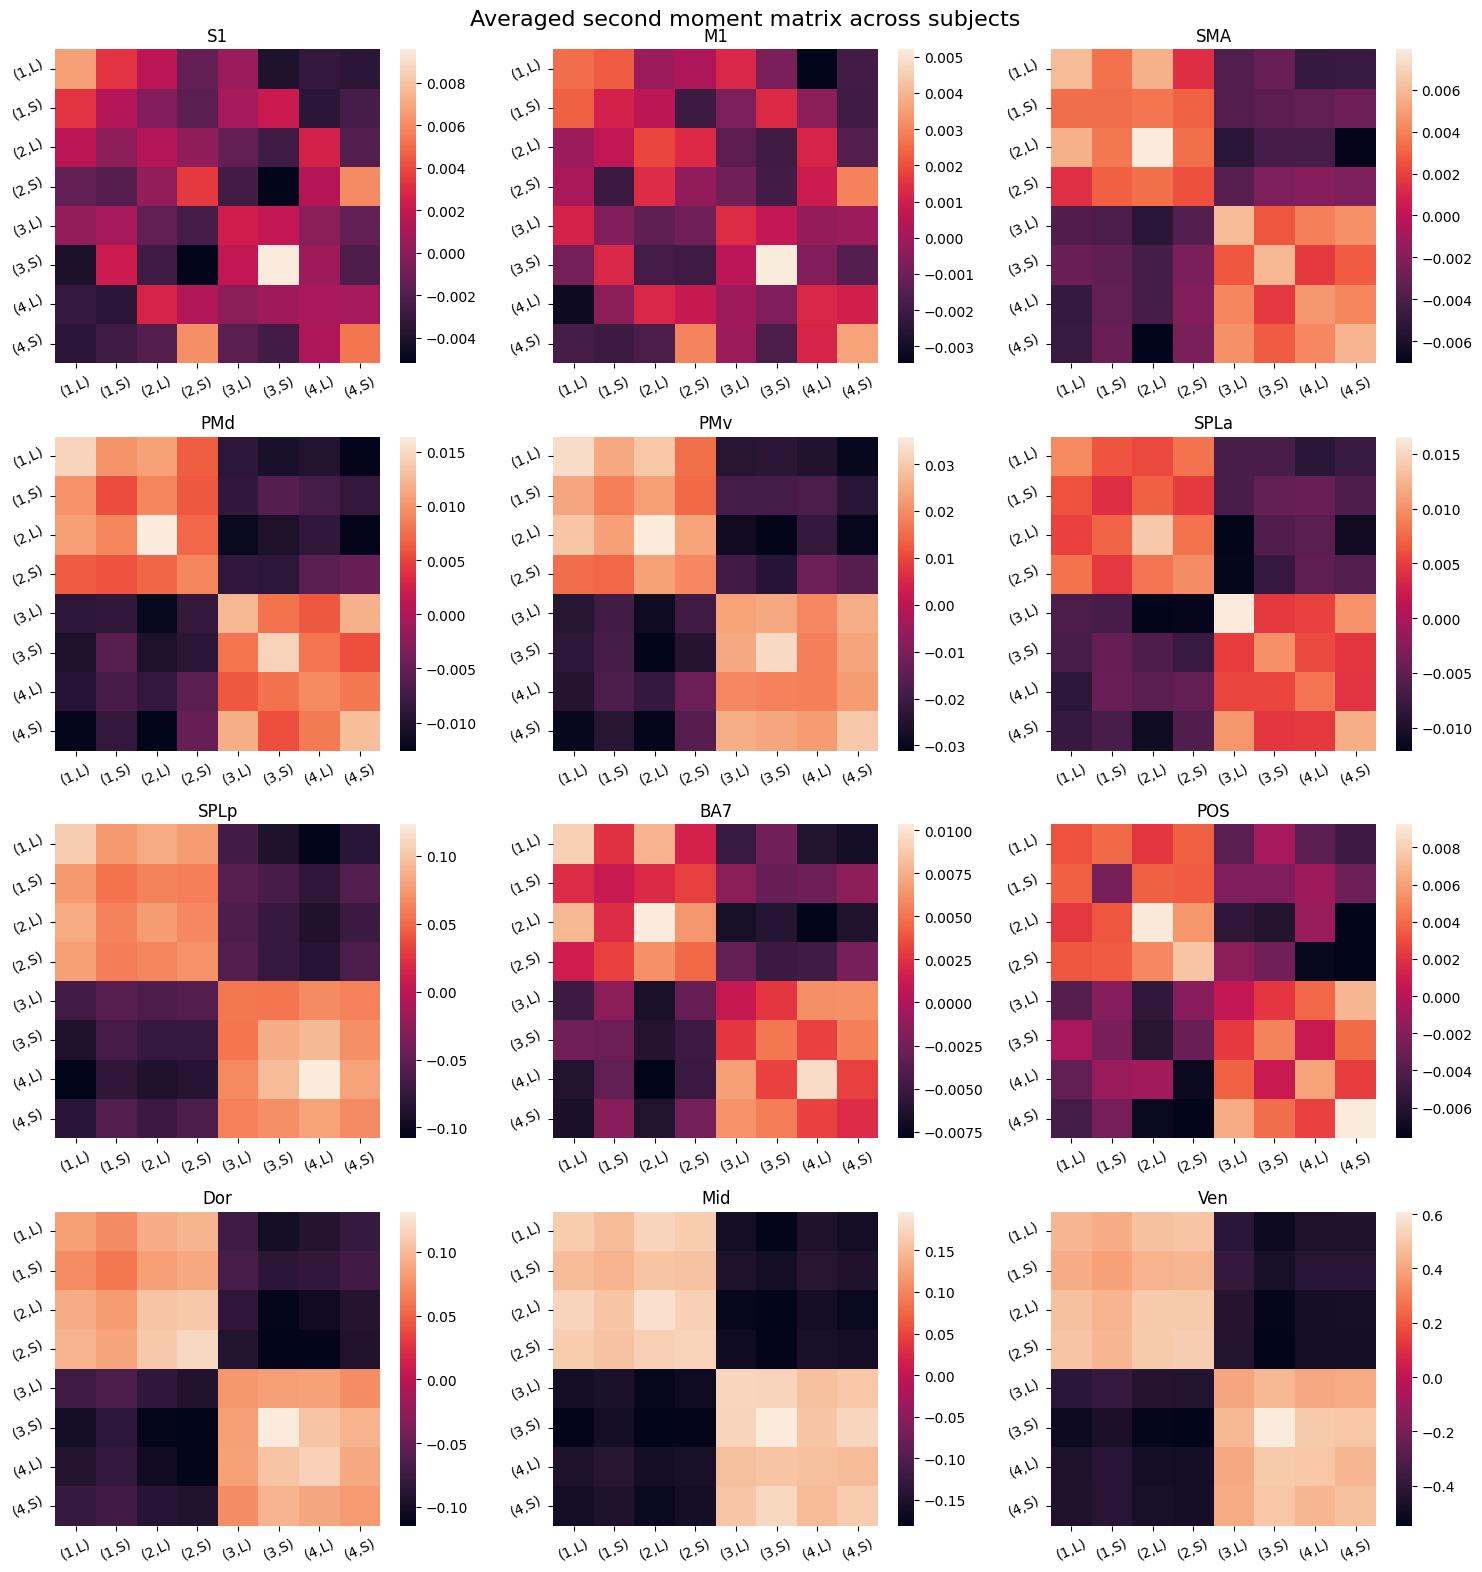

In [38]:
nrows, ncols = 4,3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols,4*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    G_avg = G_hat_dataset[roi].mean(axis=0)
    g = sns.heatmap(
        rearrange_mat(square_mat=G_avg, label_orig=labels, label_arrange=new_labels),
        ax=ax
    )
    g.set_xticks(g.get_xticks(), labels, rotation=25)
    g.set_yticks(g.get_yticks(), labels, rotation=25)
    g.set_title(roi)

fig.suptitle('Averaged second moment matrix across subjects', fontsize=16)
fig.tight_layout()

In [21]:
# G_hat = dict_G_hat['SPLa']

# g = sns.heatmap(G_hat[0])
# g.set_title('Cross-validated G matrix')

---

## Euclidean distance

From the second moment matrix it is possible to calculate the **squared Euclidean distances** between activity patterns observed in condition. Each pattern of activity $|\beta_{k}\rangle$ is a P-dimensional vector, where P is the number of voxels in which the activity about the condition $k$ was sampled. In the example dataset we are using in this tutorial, $ROI=S1$ contains 1152 voxels, so each activity pattern is 1152-dimensional vector. The squared Euclidean distance between two vectors $ |\beta_{i}\rangle $ and $ |\beta_{j}\rangle $ is:

$$ \mathsf{D}_{ij}^2 = (\langle\beta_{i}| - \langle\beta_{j}|)(|\beta_{i}\rangle - |\beta_{j}\rangle) $$

Expanding the terms inside the parentheses:

$$ \mathsf{D}_{ij}^2 = \langle\beta_{i}|\beta_{i}\rangle - 2\langle\beta_{i}|\beta_{j}\rangle + \langle\beta_{j}|\beta_{j}\rangle $$

If we look back at the definition of second moment matrix, for any $i$ and $j$:

$$ {G}_{ij} = \frac{\langle\beta_{i}|\beta_{j}\rangle}{P} $$

Therefore, we can rewrite the squared Euclidean distance formula for the first block:

$$ {D}_{ij}^2 \propto G_{ii} - 2G_{ij} + G_{jj} $$

In PcmPy, we can compute the ${D}^2$ from $G$ using the `G_to_dist` function:

As a consequence, the expected estimate of distance between two conditions $|\beta_{n,i}\rangle$ and $|\beta_{n,j}\rangle$ in the $n$-th block becomes:

$$\mathbb{E}[\hat{D}_{n,ij}^2] = \langle\beta_{n,i}|\beta_{n,i}\rangle + \langle\epsilon_{n,i}| \epsilon_{n,i}\rangle - 2\big(\langle\beta_{n,i}|\beta_{n,j}\rangle + \langle\epsilon_{n,i}|\epsilon_{n,j}\rangle\big) + \langle\beta_{n,j}|\beta_{n,j}\rangle + \langle\epsilon_{n,j}|\epsilon_{n,j}\rangle $$

That is, the estimate of the distance $\hat{D}_{n,ij}^2$ is inflated by $ \langle\epsilon_{n,i} |\epsilon_{n,i}\rangle -2\langle\epsilon_{n,i}|\epsilon_{n,j}\rangle +  \langle\epsilon_{n,j}|\epsilon_{n,j}\rangle$

If you are more used to looking in representational dissimilarity matrices (RDMs), you can also transform the second momement matrix into this (see Diedrichsen & Kriegeskorte,2017)
$$
diag(CGC^{T}) \rightarrow RDM
$$

In [39]:
D_cv_dataset = {}
for roi in list_roi:
    tmp = []
    G_hat = G_hat_dataset[roi]
    for ss, sn in enumerate(list_sn):
        D = pcm.G_to_dist(G_hat[ss])
        tmp.append(D)
    D_cv_dataset[roi] = np.array(tmp)

In [40]:
for key, value in D_cv_dataset.items():
    print(key, value.shape)

S1 (12, 8, 8)
M1 (12, 8, 8)
SMA (12, 8, 8)
PMd (12, 8, 8)
PMv (12, 8, 8)
SPLa (12, 8, 8)
SPLp (12, 8, 8)
BA7 (12, 8, 8)
POS (12, 8, 8)
Dor (12, 8, 8)
Mid (12, 8, 8)
Ven (12, 8, 8)


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.04it/s]


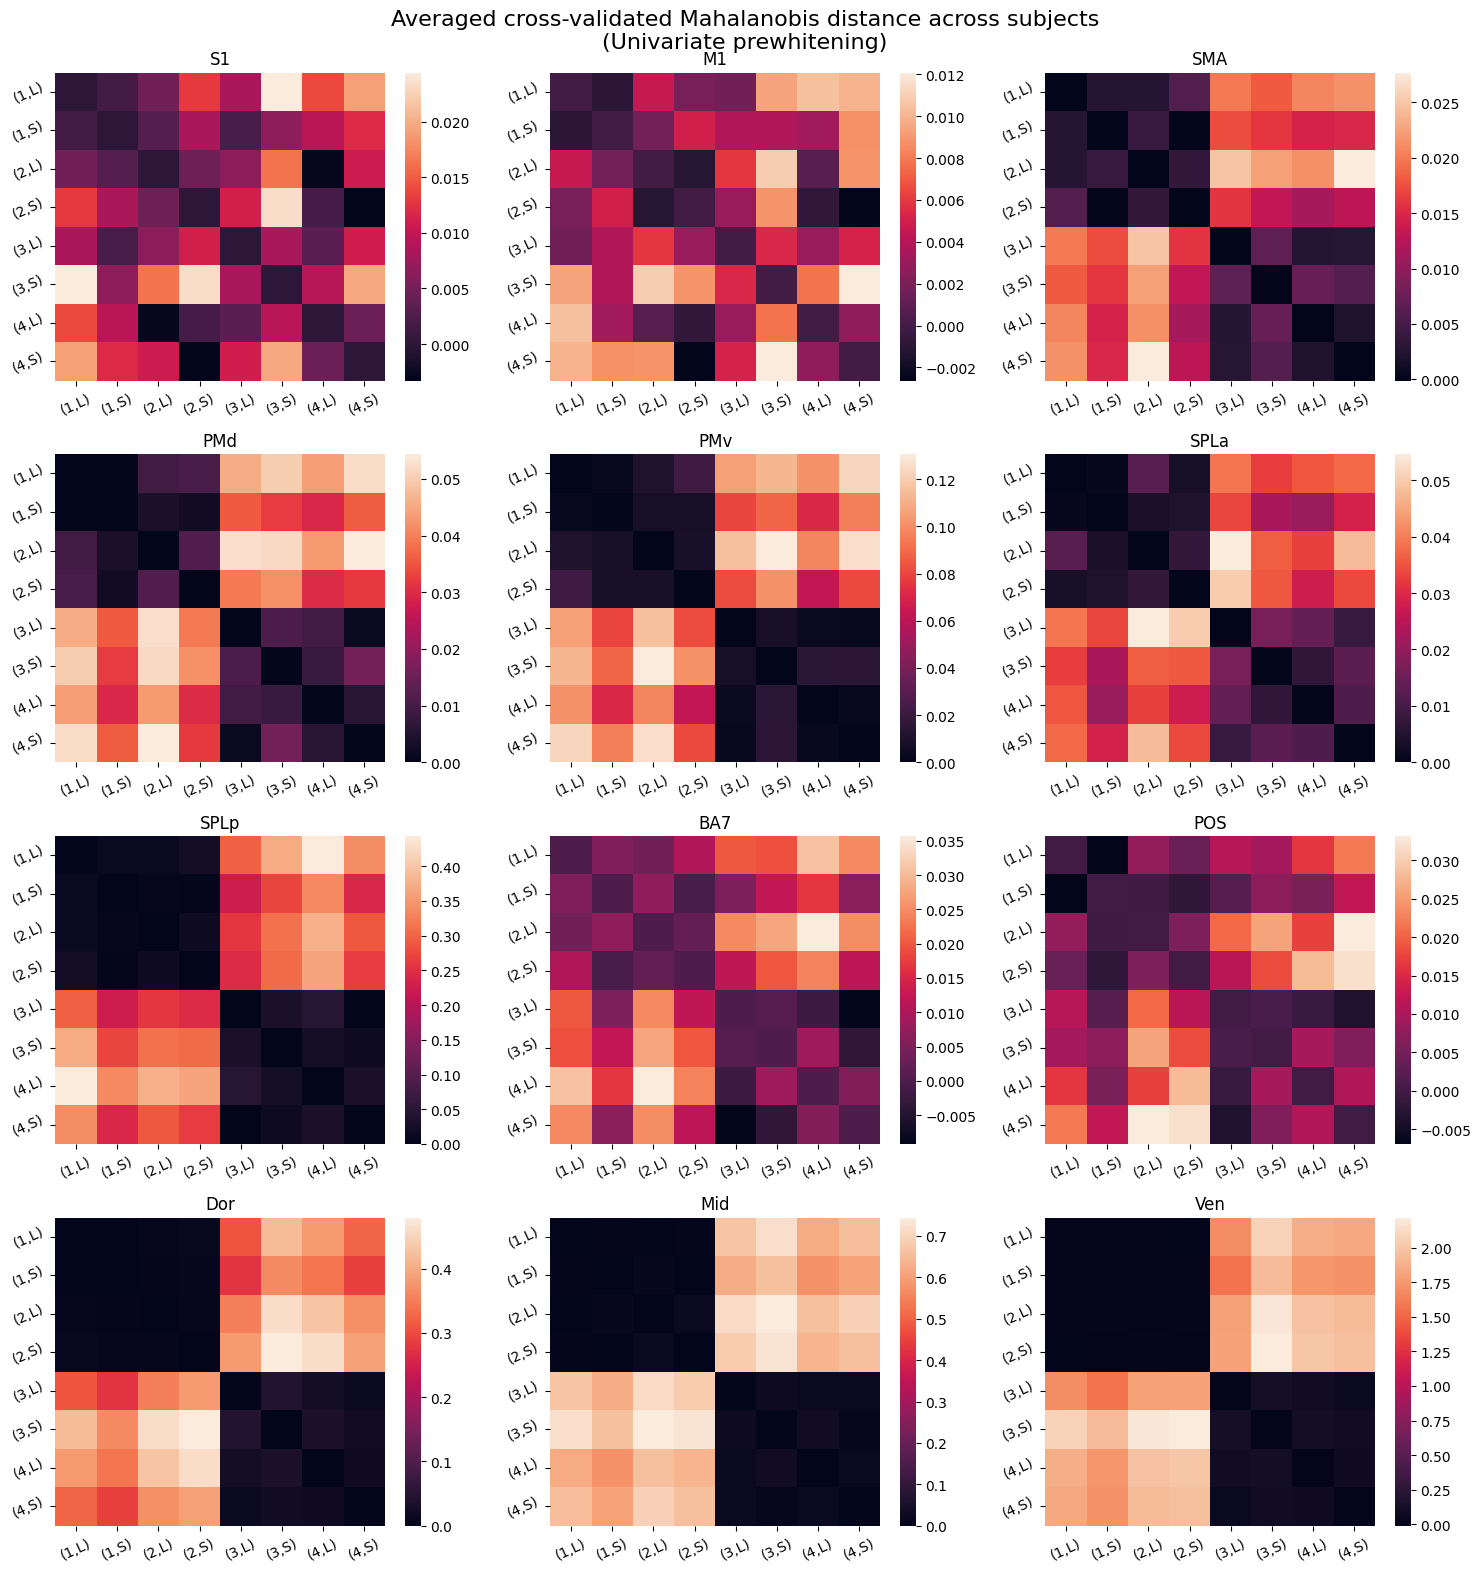

In [41]:
nrows, ncols = 4,3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols,4*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    D_avg = D_cv_dataset[roi].mean(axis=0)
    g = sns.heatmap(
        rearrange_mat(square_mat=D_avg, label_orig=labels, label_arrange=new_labels),
        ax=ax
    )
    g.set_xticks(g.get_xticks(), labels, rotation=25)
    g.set_yticks(g.get_yticks(), labels, rotation=25)
    g.set_title(roi)

fig.suptitle('Averaged cross-validated Mahalanobis distance across subjects\n(Univariate prewhitening)', fontsize=16)
fig.tight_layout()

## 1. Sequence (Same vs. Diff)

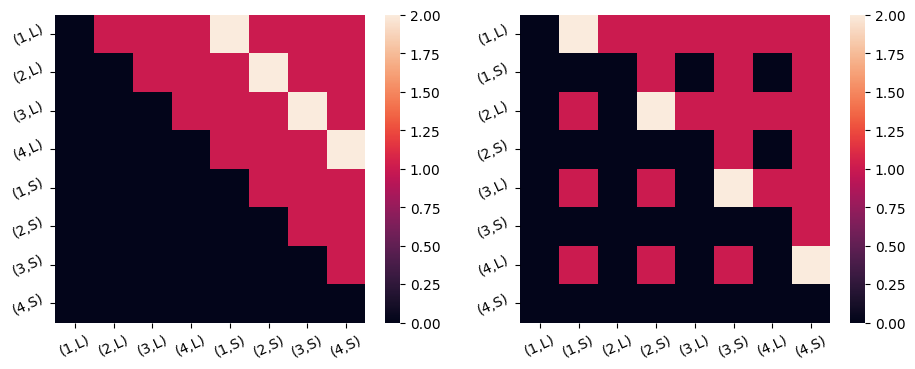

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(11,4))

matrix_idx = np.zeros((8,8))

for ii, c1 in enumerate(new_labels):
    row = ii
    for jj, c2 in enumerate(new_labels[ii+1:]):
        col = jj + ii + 1
        ## upper triangle would be 1
        matrix_idx[row, col] += 1

        ## same sequence
        if c1[1]==c2[1]:
            matrix_idx[row, col] += 1

g = sns.heatmap(matrix_idx, ax=axs[0])
g.set_xticks(g.get_xticks(), new_labels, rotation=25)
g.set_yticks(g.get_yticks(), new_labels, rotation=25)

g = sns.heatmap(
    rearrange_mat(square_mat=matrix_idx,label_orig=new_labels,label_arrange=labels),
    ax=axs[1]
)
g.set_xticks(g.get_xticks(), labels, rotation=25)
g.set_yticks(g.get_yticks(), labels, rotation=25)

In [43]:
lines = []
for roi in list_roi:
    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        D_cv = D_cv_dataset[roi][ss]
        D_DiffSeq = D_cv*(matrix_idx==1)
        D_DiffSeq = D_DiffSeq.mean()
        D_SameSeq = D_cv*(matrix_idx==2)
        D_SameSeq = D_SameSeq.mean()
        lines.append(
            {'roi':roi, 'sess':subj[0], 'subj':subj[1:], 'D_DiffSeq':D_DiffSeq, 'D_SameSeq':D_SameSeq}
        )
df = pd.DataFrame(lines)
df

,roi,sess,subj,D_DiffSeq,D_SameSeq
0,S1,S,01,0.006023,0.000992
1,S1,S,02,0.007227,0.001355
2,S1,S,03,0.003141,0.000395
3,S1,S,05,0.001766,0.000372
4,S1,S,06,0.001405,0.000320
...,...,...,...,...,...
139,Ven,S,10,0.731505,0.001436
140,Ven,S,11,0.605762,0.011414
141,Ven,S,12,0.400075,0.002339
142,Ven,S,13,1.083790,0.002363


In [ ]:
# sess = 'S'
# data = df[df.sess==sess]

# fig, axs = plt.subplots(ncols=2, figsize=(12,5))

# for ii, val in enumerate(['D_SameSeq','D_DiffSeq']):
#     ax = axs[ii]
#     g = sns.barplot(
#         data=data,
#         x='roi', y=val,
#         errorbar='se', capsize=0.15,
#         ax=ax
#     )
#     g.set_title('sess %s'%sess)
#     g.grid(axis='y', linestyle='--')
#     g.set_ylim(0., 0.04)
    
#     dy = np.diff(g.get_ylim())*0.025
    
#     for ii, roi in enumerate(list_roi):
#         a = data[(data.roi==roi)][val].astype(float)
#         res = ttest_1samp(a, popmean=0)
#         if res.pvalue < 0.05:
#             print(roi, sess, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
#             x = ii
#             y = a.mean()+a.sem()
#             g.text(
#                 x=x, y=y,
#                 s=su.convert_pval_to_star(res.pvalue), fontsize=10,
#                 ha='center', va='bottom'
#             )

S1 t(11)=2.8491, p=1.582e-02(*)
M1 t(11)=2.7569, p=1.866e-02(*)
SMA t(11)=2.2534, p=4.561e-02(*)
PMd t(11)=3.8895, p=2.522e-03(**)
PMv t(11)=4.7298, p=6.196e-04(***)
SPLa t(11)=4.3285, p=1.198e-03(**)
SPLp t(11)=2.2070, p=4.948e-02(*)
Dor t(11)=2.6214, p=2.377e-02(*)
Ven t(11)=2.8556, p=1.564e-02(*)
S1 t(11)=4.2503, p=1.365e-03(**)
M1 t(11)=3.1604, p=9.073e-03(**)
SMA t(11)=3.4736, p=5.207e-03(**)
PMd t(11)=4.2193, p=1.438e-03(**)
PMv t(11)=3.6021, p=4.155e-03(**)
SPLa t(11)=7.4125, p=1.339e-05(****)
SPLp t(11)=2.4867, p=3.021e-02(*)
BA7 t(11)=3.6694, p=3.694e-03(**)
POS t(11)=4.3578, p=1.140e-03(**)
Dor t(11)=3.5137, p=4.852e-03(**)
Mid t(11)=3.8497, p=2.701e-03(**)
Ven t(11)=6.0008, p=8.916e-05(****)


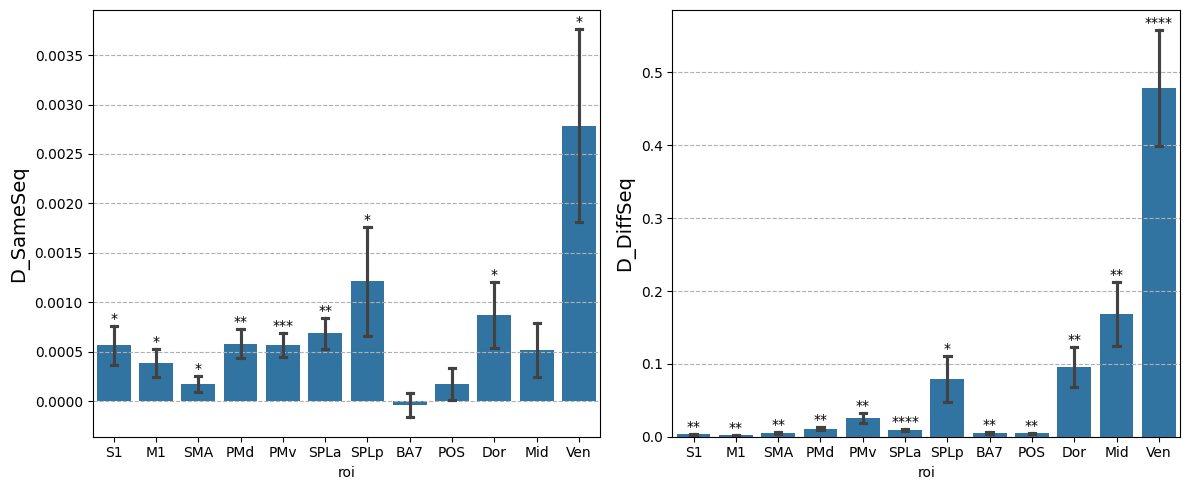

In [44]:
data = df.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, val in enumerate(['D_SameSeq','D_DiffSeq']):
    ax = axs[ii]
    g = sns.barplot(
        data=data,
        x='roi', y=val, order=list_roi,
        errorbar='se', capsize=0.15,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    # g.set_ylim(0., 0.042)
    g.set_ylabel(val, fontsize=14)
    
    dy = np.diff(g.get_ylim())*0.025
    
    for jj, roi in enumerate(list_roi):
        a = data[(data.roi==roi)][val].astype(float)
        res = ttest_1samp(a, popmean=0)
        if res.pvalue < 0.05:
            print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
            x = jj
            y = a.mean()+a.sem()
            g.text(
                x=x, y=y,
                s=sstat.convert_pval_to_star(res.pvalue), fontsize=10,
                ha='center', va='bottom'
            )
fig.tight_layout()

## 2. Cue (Same vs. Diff)

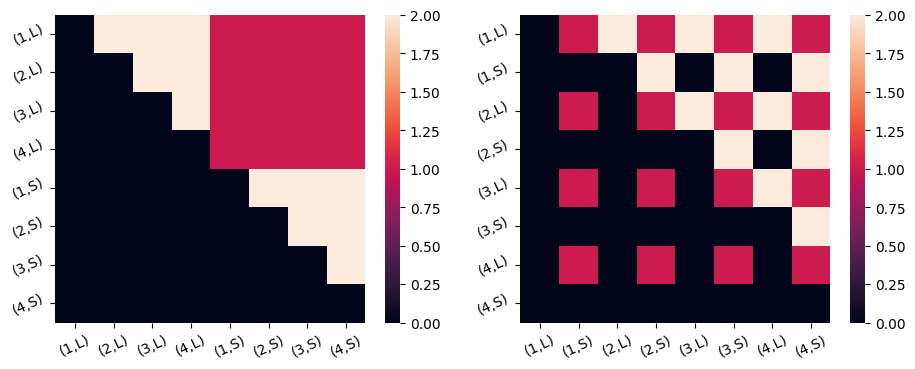

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(11,4))

matrix_idx = np.zeros((8,8))

for ii, c1 in enumerate(new_labels):
    row = ii
    for jj, c2 in enumerate(new_labels[ii+1:]):
        col = jj + ii + 1
        ## upper triangle would be 1
        matrix_idx[row, col] += 1

        ## same cue
        if c1[-2]==c2[-2]:
            matrix_idx[row, col] += 1

g = sns.heatmap(matrix_idx, ax=axs[0])
g.set_xticks(g.get_xticks(), new_labels, rotation=25)
g.set_yticks(g.get_yticks(), new_labels, rotation=25)

g = sns.heatmap(
    rearrange_mat(square_mat=matrix_idx,label_orig=new_labels,label_arrange=labels),
    ax=axs[1]
)
g.set_xticks(g.get_xticks(), labels, rotation=25)
g.set_yticks(g.get_yticks(), labels, rotation=25)

In [46]:
lines = []
for roi in list_roi:
    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        D_cv = D_cv_dataset[roi][ss]
        D_DiffCue = D_cv*(matrix_idx==1)
        D_DiffCue = D_DiffCue.mean()
        D_SameCue = D_cv*(matrix_idx==2)
        D_SameCue = D_SameCue.mean()
        lines.append(
            {'roi':roi, 'sess':subj[0], 'subj':subj[1:], 'D_DiffCue':D_DiffCue, 'D_SameCue':D_SameCue}
        )
df = pd.DataFrame(lines)
df

,roi,sess,subj,D_DiffCue,D_SameCue
0,S1,S,01,0.005179,0.001836
1,S1,S,02,0.005294,0.003287
2,S1,S,03,0.002506,0.001029
3,S1,S,05,0.001618,0.000520
4,S1,S,06,0.000980,0.000744
...,...,...,...,...,...
139,Ven,S,10,0.366653,0.366289
140,Ven,S,11,0.308924,0.308252
141,Ven,S,12,0.204557,0.197857
142,Ven,S,13,0.543794,0.542359


S1 t(11)=2.3600, p=3.782e-02(*)
SMA t(11)=3.2816, p=7.313e-03(**)
PMd t(11)=4.1841, p=1.526e-03(**)
PMv t(11)=3.4190, p=5.734e-03(**)
SPLa t(11)=8.3162, p=4.510e-06(****)
SPLp t(11)=2.5042, p=2.929e-02(*)
BA7 t(11)=3.6084, p=4.109e-03(**)
POS t(11)=3.8050, p=2.918e-03(**)
Dor t(11)=3.5236, p=4.769e-03(**)
Mid t(11)=3.8746, p=2.587e-03(**)
Ven t(11)=6.0040, p=8.876e-05(****)
S1 t(11)=4.2516, p=1.362e-03(**)
M1 t(11)=3.7654, p=3.125e-03(**)
SMA t(11)=3.6922, p=3.550e-03(**)
PMd t(11)=4.2674, p=1.327e-03(**)
PMv t(11)=3.8860, p=2.537e-03(**)
SPLa t(11)=6.4903, p=4.487e-05(****)
SPLp t(11)=2.5065, p=2.917e-02(*)
BA7 t(11)=3.4040, p=5.887e-03(**)
POS t(11)=4.0203, p=2.015e-03(**)
Dor t(11)=3.5062, p=4.916e-03(**)
Mid t(11)=3.8077, p=2.904e-03(**)
Ven t(11)=6.0237, p=8.628e-05(****)


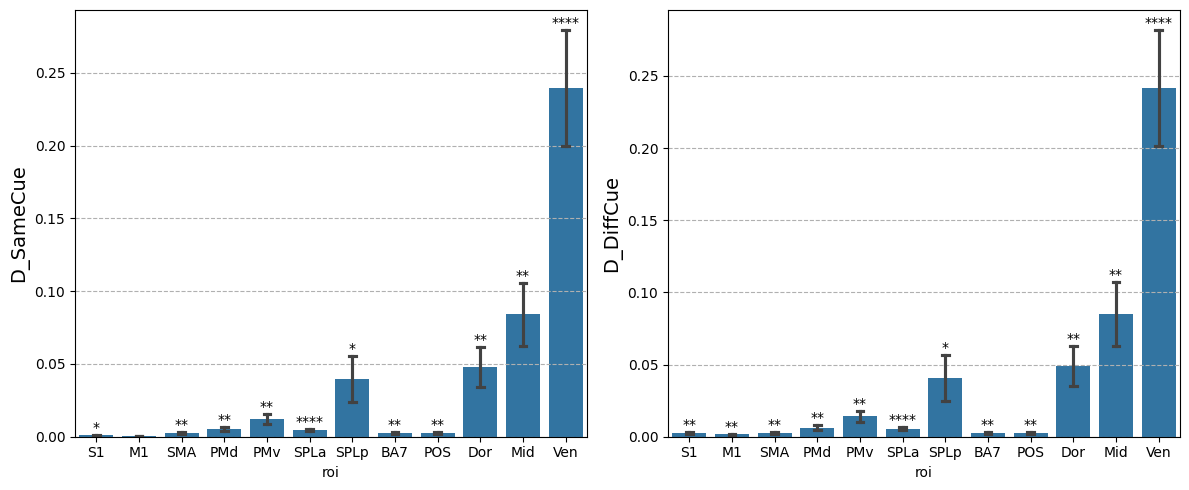

In [47]:
data = df.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, val in enumerate(['D_SameCue','D_DiffCue']):
    ax = axs[ii]
    g = sns.barplot(
        data=data,
        x='roi', y=val, order=list_roi,
        errorbar='se', capsize=0.15,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    # g.set_ylim(0., 0.053)
    g.set_ylabel(val, fontsize=14)
    
    dy = np.diff(g.get_ylim())*0.025
    
    for jj, roi in enumerate(list_roi):
        a = data[(data.roi==roi)][val].astype(float)
        res = ttest_1samp(a, popmean=0)
        if res.pvalue < 0.05:
            print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
            x = jj
            y = a.mean()+a.sem()
            g.text(
                x=x, y=y,
                s=sstat.convert_pval_to_star(res.pvalue), fontsize=10,
                ha='center', va='bottom'
            )
fig.tight_layout()

## 3. First Finger (Same vs. Diff)

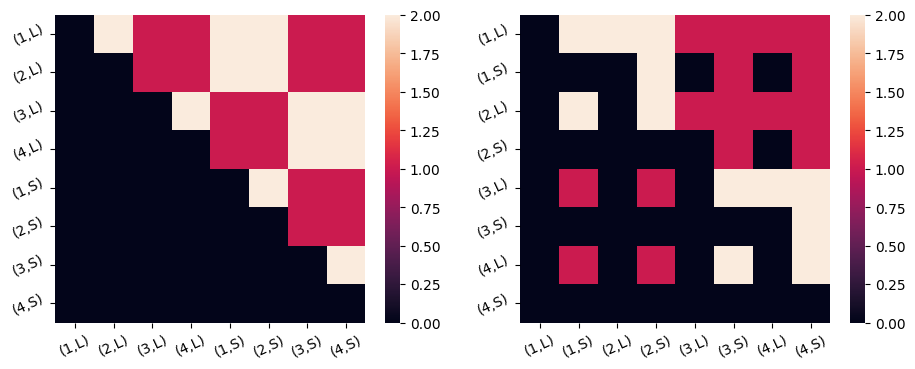

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(11,4))

matrix_idx = np.zeros((8,8))

for ii, c1 in enumerate(new_labels):
    row = ii
    for jj, c2 in enumerate(new_labels[ii+1:]):
        col = jj + ii + 1
        ## upper triangle would be 1
        matrix_idx[row, col] += 1

        ## same first
        s1 = int(c1[1])
        s2 = int(c2[1])
        if (s1-2.5)*(s2-2.5)>0:
            matrix_idx[row, col] += 1

g = sns.heatmap(matrix_idx, ax=axs[0])
g.set_xticks(g.get_xticks(), new_labels, rotation=25)
g.set_yticks(g.get_yticks(), new_labels, rotation=25)

g = sns.heatmap(
    rearrange_mat(square_mat=matrix_idx,label_orig=new_labels,label_arrange=labels),
    ax=axs[1]
)
g.set_xticks(g.get_xticks(), labels, rotation=25)
g.set_yticks(g.get_yticks(), labels, rotation=25)

In [49]:
lines = []
for roi in list_roi:
    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        D_cv = D_cv_dataset[roi][ss]
        D_DiffCue = D_cv*(matrix_idx==1)
        D_DiffCue = D_DiffCue.mean()
        D_SameCue = D_cv*(matrix_idx==2)
        D_SameCue = D_SameCue.mean()
        lines.append(
            {'roi':roi, 'sess':subj[0], 'subj':subj[1:], 'D_DiffFirst':D_DiffCue, 'D_SameFirst':D_SameCue}
        )
df = pd.DataFrame(lines)
df

,roi,sess,subj,D_DiffFirst,D_SameFirst
0,S1,S,01,0.003579,0.003436
1,S1,S,02,0.004938,0.003643
2,S1,S,03,0.001738,0.001798
3,S1,S,05,0.001325,0.000813
4,S1,S,06,0.000846,0.000878
...,...,...,...,...,...
139,Ven,S,10,0.366521,0.366421
140,Ven,S,11,0.312055,0.305121
141,Ven,S,12,0.203294,0.199120
142,Ven,S,13,0.545287,0.540866


S1 t(11)=3.3109, p=6.942e-03(**)
M1 t(11)=2.8695, p=1.526e-02(*)
SMA t(11)=3.5597, p=4.475e-03(**)
PMd t(11)=4.3021, p=1.252e-03(**)
PMv t(11)=3.6639, p=3.729e-03(**)
SPLa t(11)=7.0978, p=1.999e-05(****)
SPLp t(11)=2.4833, p=3.039e-02(*)
BA7 t(11)=3.2159, p=8.218e-03(**)
POS t(11)=3.9957, p=2.102e-03(**)
Dor t(11)=3.4818, p=5.132e-03(**)
Mid t(11)=3.7855, p=3.018e-03(**)
Ven t(11)=6.0107, p=8.790e-05(****)
S1 t(11)=4.7342, p=6.151e-04(***)
M1 t(11)=3.2397, p=7.878e-03(**)
SMA t(11)=3.4427, p=5.498e-03(**)
PMd t(11)=4.1958, p=1.496e-03(**)
PMv t(11)=3.6533, p=3.799e-03(**)
SPLa t(11)=7.4994, p=1.201e-05(****)
SPLp t(11)=2.5274, p=2.810e-02(*)
BA7 t(11)=3.8000, p=2.943e-03(**)
POS t(11)=3.9676, p=2.205e-03(**)
Dor t(11)=3.5460, p=4.584e-03(**)
Mid t(11)=3.8941, p=2.502e-03(**)
Ven t(11)=6.0176, p=8.704e-05(****)


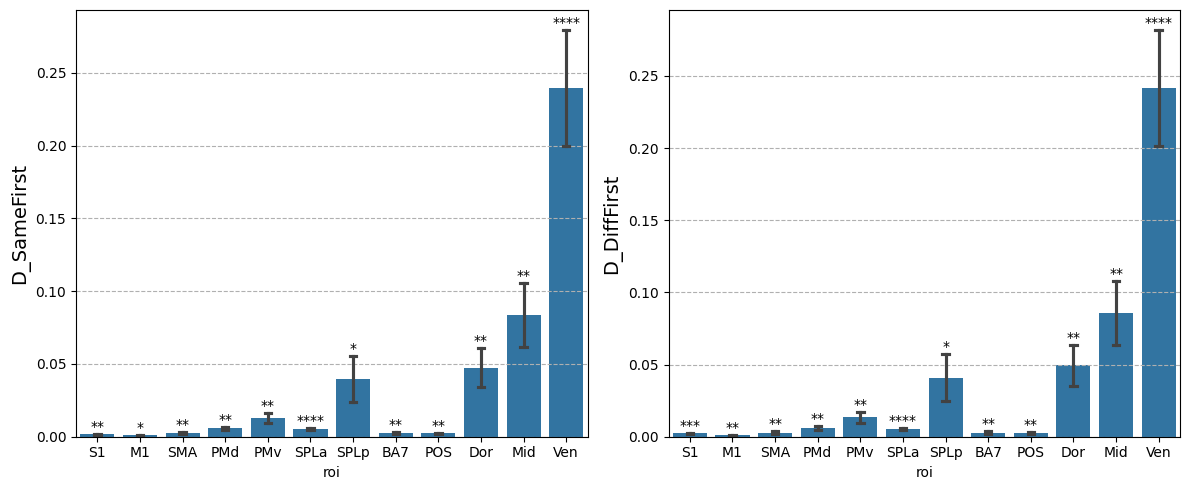

In [50]:
data = df.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, val in enumerate(['D_SameFirst','D_DiffFirst']):
    ax = axs[ii]
    g = sns.barplot(
        data=data,
        x='roi', y=val, order=list_roi,
        errorbar='se', capsize=0.15,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    # g.set_ylim(0., 0.030)
    g.set_ylabel(val, fontsize=14)
    
    dy = np.diff(g.get_ylim())*0.025
    
    for jj, roi in enumerate(list_roi):
        a = data[(data.roi==roi)][val].astype(float)
        res = ttest_1samp(a, popmean=0)
        if res.pvalue < 0.05:
            print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
            x = jj
            y = a.mean()+a.sem()
            g.text(
                x=x, y=y,
                s=sstat.convert_pval_to_star(res.pvalue), fontsize=10,
                ha='center', va='bottom'
            )
fig.tight_layout()

---